In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [28]:
data = pd.read_csv('wine.csv')

X = data.iloc[:, 1:].values  
y = data.iloc[:, 0].values 

y = y - 1 

In [29]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [32]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(13, 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 3)  
        self.relu = nn.ReLU()         

    def forward(self, x):
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.fc3(x)  
        return x

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)

In [34]:
loss_values = []

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [35]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


In [36]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()  
    
    optimizer.zero_grad()  
    outputs = model(X_train)  
    loss = criterion(outputs, y_train)  
    loss.backward()  
    optimizer.step()  

    loss_values.append(loss.item())  
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/30], Loss: 0.1439
Epoch [20/30], Loss: 0.0044
Epoch [30/30], Loss: 0.0003


In [37]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)  
    _, predicted = torch.max(outputs, 1)  


In [38]:
y_test_np = y_test.cpu().numpy()
predicted_np = predicted.cpu().numpy()


In [39]:
conf_matrix = confusion_matrix(y_test_np, predicted_np)
accuracy = accuracy_score(y_test_np, predicted_np)
precision = precision_score(y_test_np, predicted_np, average='macro')
recall = recall_score(y_test_np, predicted_np, average='macro')
f1 = f1_score(y_test_np, predicted_np, average='macro')

# Print Results
print("Confusion Matrix:\n", conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Confusion Matrix:
 [[14  0  0]
 [ 0 14  0]
 [ 0  0  8]]
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00


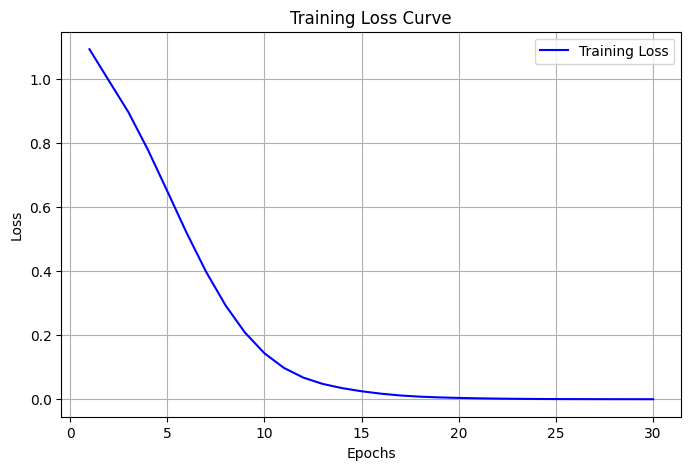

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, label="Training Loss", color='b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [51]:
train_dataset = TensorDataset(X_train, y_train)

In [52]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [41]:
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(13, 64)  
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 1)   
        self.relu = nn.ReLU()         

    def forward(self, x):
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.fc3(x)  
        return x

In [42]:
model_reg = MLPRegressor().to(device)

In [43]:
loss_values_reg = []


In [44]:
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.01)


In [53]:
num_epochs = 100
loss_values_reg = []  

for epoch in range(num_epochs):
    model_reg.train()  
    epoch_loss = 0.0  
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_reg.zero_grad()  
        outputs = model_reg(inputs)  
        loss = criterion_reg(outputs, labels.float().unsqueeze(1))  
        loss.backward()  
        optimizer_reg.step()  
        epoch_loss += loss.item()  
    epoch_loss /= len(train_loader)
    loss_values_reg.append(epoch_loss)  
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [10/100], Loss: 0.0012
Epoch [20/100], Loss: 0.0028
Epoch [30/100], Loss: 0.0023
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0010
Epoch [80/100], Loss: 0.0009
Epoch [90/100], Loss: 0.0015
Epoch [100/100], Loss: 0.0004


In [54]:
model_reg.eval()
with torch.no_grad():
    outputs = model_reg(X_test)  # Forward pass
    mse = criterion_reg(outputs, y_test.float().unsqueeze(1))
    print(f"Test MSE: {mse.item():.4f}")


Test MSE: 0.0187


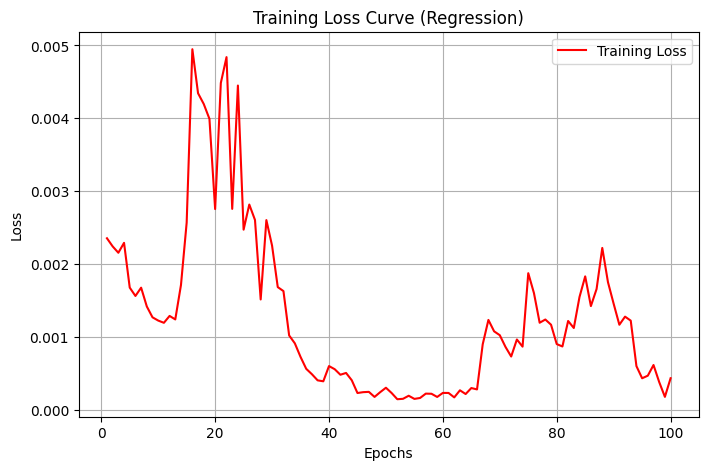

In [55]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values_reg, label="Training Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Regression)")
plt.legend()
plt.grid()
plt.show()

In [56]:

hidden_size = 128
learning_rate = 0.001
momentum = 0.9

model = MLPClassifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    print(f"Test Accuracy after tuning: {accuracy * 100:.2f}%")

Epoch [10/100], Loss: 1.0899
Epoch [20/100], Loss: 1.0740
Epoch [30/100], Loss: 1.0551
Epoch [40/100], Loss: 1.0354
Epoch [50/100], Loss: 1.0151
Epoch [60/100], Loss: 0.9943
Epoch [70/100], Loss: 0.9729
Epoch [80/100], Loss: 0.9507
Epoch [90/100], Loss: 0.9275
Epoch [100/100], Loss: 0.9032
Test Accuracy after tuning: 88.89%
